In [38]:
import os
import pickle
import numpy as np
from IPython.display import clear_output
import matplotlib
import matplotlib.pyplot as plt
#import config InlineBackend.figure_format = 'svg'
import tensorflow as tf
# silencing tensorflow warnings
import logging
logging.getLogger('tensorflow').setLevel(logging.FATAL)
from datetime import datetime
tf.__version__ # printint out tensorflow version used
import stable_baselines3
import sb3_contrib
from stable_baselines3.common.callbacks import BaseCallback
# from stable_baselines3.results_plotter import load_results, ts2xy
from stable_baselines3.common.results_plotter import load_results, ts2xy
import optuna
# from stable_baselines3.bench import Monitor
from stable_baselines3.common.monitor import Monitor
#from stable_baselines3.common.policies import MlpPolicy
from stable_baselines3.common import results_plotter
from sb3_contrib.common.maskable.evaluation import evaluate_policy
from sb3_contrib import MaskablePPO
from stable_baselines3.common.vec_env import DummyVecEnv
#stable_baselines.__version__ # printing out stable_baselines version used
import gym
import pickle
import cProfile 
import pandas as pd
font = { 'family' : 'sans-serif',
                'weight' : 'normal',
                'size'   : 12}
matplotlib.rc('font', **font)

In [2]:
with open('/Users/joshnevin/RL_FOCSLab/topologies/nsfnet_chen_5-paths_directional.h5', 'rb') as f:
    topology = pickle.load(f)
# node probabilities from https://github.com/xiaoliangchenUCD/DeepRMSA/blob/6708e9a023df1ec05bfdc77804b6829e33cacfe4/Deep_RMSA_A3C.py#L77
node_request_probabilities = np.array([0.01801802, 0.04004004, 0.05305305, 0.01901902, 0.04504505,
       0.02402402, 0.06706707, 0.08908909, 0.13813814, 0.12212212,
       0.07607608, 0.12012012, 0.01901902, 0.16916917])
load = int(1e10)
env_args = dict(topology=topology, seed=5, load = load,
                allow_rejection=False, # the agent cannot proactively reject a request
                mean_service_holding_time=1e8, # value is not set as in the paper to achieve comparable reward values
                episode_length=1600, node_request_probabilities=node_request_probabilities, exp_request_res=25e9,
                exp_request_lambda=1, term_on_first_block=True)

In [49]:
current_directory = os.getcwd()
# exp_id = "2022-01-18tbf10Mdict"
exp_id = "2022-01-15_maskedppomulproc"
env_id = "RWAFOCS-v41"
eval_dir = "/Users/joshnevin/RL_FOCSLab/tmp/RWAFOCS-ppo/"+exp_id+"/_core_0/eval_results"

In [54]:
def get_info(eval_dir, model):
    df = pd.read_csv(eval_dir+"/evaluation_"+model+".monitor.csv", skiprows=1)
    eval_eps = df.index.values
    rewards = df['r'].to_numpy()
    sim_time = df['t'].to_numpy()
    services_accepted_ep = df['episode_services_accepted']
    services_processed_ep = df['episode_services_processed']
    services_accepted = df['services_accepted']
    services_processed = df['services_processed']
    throughput = df['throughput']/1e12
    return rewards, eval_eps, sim_time, services_accepted_ep, services_processed_ep, services_accepted, services_processed, throughput

In [55]:
rewards_rl, eval_eps_rl, sim_time_rl, services_accepted_ep_rl, services_processed_ep_rl, services_accepted_rl, services_processed_rl, throughput_rl = get_info(eval_dir, 'rl')
rewards_kspff, eval_eps_kspff, sim_time_kspff, services_accepted_ep_kspff, services_processed_ep_kspff, services_accepted_kspff, services_processed_kspff, throughput_kspff = get_info(eval_dir, 'kspff')
rewards_ffksp, eval_eps_ffksp, sim_time_ffksp, services_accepted_ep_ffksp, services_processed_ep_ffksp, services_accepted_ffksp, services_processed_ffksp, throughput_ffksp = get_info(eval_dir, 'ffksp')
rewards_camu, eval_eps_camu, sim_time_camu, services_accepted_ep_camu, services_processed_ep_camu, services_accepted_camu, services_processed_camu, throughput_camu = get_info(eval_dir, 'camu')
rewards_kspmu, eval_eps_kspmu, sim_time_kspmu, services_accepted_ep_kspmu, services_processed_ep_kspmu, services_accepted_kspmu, services_processed_kspmu, throughput_kspmu = get_info(eval_dir, 'kspmu')

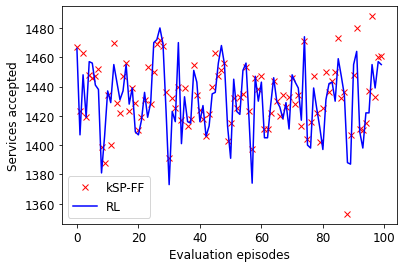

In [63]:
plt.plot(eval_eps_kspff, services_accepted_ep_kspff, 'rx', label='kSP-FF')
# plt.plot(eval_eps_ffksp, services_accepted_ep_ffksp, 'rP', label='FF-kSP')
# plt.plot(eval_eps_camu, services_accepted_ep_camu, 'k.', label='CA-MU')
# plt.plot(eval_eps_kspmu, services_accepted_ep_kspmu, 'm*', label='kSP-MU')
plt.plot(eval_eps_rl, services_accepted_ep_rl, 'b-', label='RL')
plt.xlabel("Evaluation episodes")
plt.ylabel("Services accepted")
plt.legend()
plt.show()

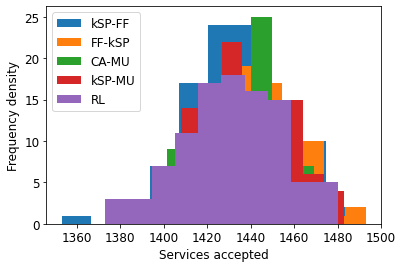

In [75]:
plt.hist(services_accepted_ep_kspff, label='kSP-FF')
plt.hist(services_accepted_ep_ffksp, label='FF-kSP')
plt.hist(services_accepted_ep_camu, label='CA-MU')
plt.hist(services_accepted_ep_kspmu, label='kSP-MU')
plt.hist(services_accepted_ep_rl, label='RL')
plt.xlabel("Services accepted")
plt.ylabel("Frequency density")
plt.legend()
plt.show()

In [76]:
print(np.mean(services_accepted_ep_rl))
print(np.mean(services_accepted_ep_kspff))
print(np.mean(services_accepted_ep_ffksp))
print(np.mean(services_accepted_ep_camu))
print(np.mean(services_accepted_ep_kspmu))

1430.94
1433.37
1439.71
1435.73
1437.52


In [77]:
print(np.std(services_accepted_ep_rl))
print(np.std(services_accepted_ep_kspff))
print(np.std(services_accepted_ep_ffksp))
print(np.std(services_accepted_ep_camu))
print(np.std(services_accepted_ep_kspmu))

23.161528446974305
22.145272633228068
20.015641383677917
19.298111306550183
20.73522606580406


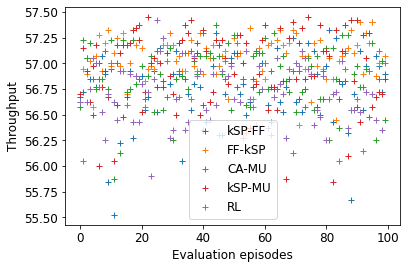

In [58]:
plt.plot(eval_eps_kspff, throughput_kspff, '+', label='kSP-FF')
plt.plot(eval_eps_ffksp, throughput_ffksp, '+', label='FF-kSP')
plt.plot(eval_eps_camu, throughput_camu, '+', label='CA-MU')
plt.plot(eval_eps_kspmu, throughput_kspmu, '+', label='kSP-MU')
plt.plot(eval_eps_rl, throughput_rl, '+', label='RL')
plt.xlabel("Evaluation episodes")
plt.ylabel("Throughput")
plt.legend()
plt.show()